In [1]:
from tsai.all import *
import sklearn.metrics as skm

from IPython.display import clear_output
computer_setup()

c:\Users\lucki\anaconda3\envs\stylegan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.22621-SP0
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.9.1+cu111
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Resteaze Data

In [2]:
# Read the data
data = pd.read_csv('final_processed.csv', index_col=0)
data

,ledGreen,accelerometer,gyroscope,sleep_state,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,hr
0,44.017837,4031.366270,218.972601,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.23489660640545
1,243.316094,4033.261614,240.587822,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.14947820780132
2,628.524031,4035.257737,262.429038,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.80195512238786
3,1037.882909,4039.649737,271.788061,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.8155375957624
4,1252.057796,4044.051063,283.347843,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.38660268613536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18362995,22.546209,4045.621244,213.984813,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.080325
18362996,22.342615,4044.926823,221.867077,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.287522
18362997,21.302988,4045.749313,238.856128,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.135145
18362998,19.550757,4046.576207,256.132778,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.064066


In [3]:
# select the columns
data = data.interpolate()[[
    'ledGreen', 'accelerometer', 'gyroscope', 'bpm', 'breathingrate', 'hr',
    'sleep_state'
]]

# drop rows where 'hr' column have values starting with '['
data = data[~data['hr'].str.startswith('[', na=False)]

In [4]:
data.reset_index(drop=True, inplace=True)

In [5]:
df = data.copy()

In [6]:
# select 1st million rows
df = df.iloc[:18361500]

In [7]:
df

,ledGreen,accelerometer,gyroscope,bpm,breathingrate,hr,sleep_state
0,44.017837,4031.366270,218.972601,NaN,NaN,37.23489660640545,0
1,243.316094,4033.261614,240.587822,NaN,NaN,36.14947820780132,0
2,628.524031,4035.257737,262.429038,NaN,NaN,34.80195512238786,0
3,1037.882909,4039.649737,271.788061,NaN,NaN,33.8155375957624,0
4,1252.057796,4044.051063,283.347843,NaN,NaN,33.38660268613536,0
...,...,...,...,...,...,...,...
18361495,-11.158270,4051.925252,243.693455,75.0,0.166667,17.636103,1
18361496,-5.812718,4051.898567,255.164653,75.0,0.166667,17.432848,1
18361497,0.404518,4048.076827,228.317761,75.0,0.166667,17.390665,1
18361498,6.903495,4048.000896,238.055666,75.0,0.166667,17.770973,1


## TSData preparation

In [452]:
# # load the npy files
# X = np.load('X.npy')
# y = np.load('y.npy')

In [547]:
df

,ledGreen,accelerometer,gyroscope,bpm,breathingrate,hr,sleep_state
0,1.428279,4190.530336,265.067916,34.883721,0.166667,8.79517,0
1,3.933569,4188.984364,263.579210,34.902132,0.166667,9.444221,0
2,6.364565,4193.186126,259.126953,34.920543,0.166667,10.60804,0
3,8.620646,4197.390168,254.879928,34.938953,0.166667,12.624369,0
4,10.742956,4201.596482,250.848560,34.957364,0.166667,15.443452,0
...,...,...,...,...,...,...,...
1574995,13.443387,4041.021900,313.552229,73.872593,0.123283,61.575012157185576,1
1574996,18.728395,4047.116041,302.673917,73.876399,0.123257,59.55205595772566,1
1574997,22.851306,4053.211690,292.685838,73.880206,0.123231,57.96628571427823,1
1574998,24.990865,4045.171535,278.275493,73.884013,0.123205,57.05743510262408,1


In [487]:
# print(X.shape, y.shape)
# tX = X[:, 0]
# ty = y
# tdata = np.concatenate((tX, ty), axis=-1)
# tdf = pd.DataFrame(tdata).astype(float)
# print(X.shape, y.shape, tX.shape, ty.shape)
# tdf

## Data from Pandas DataFrame


In [439]:
df = data.copy()
# select 1st million rows
df = df.iloc[:1575000]
# df

In [440]:
# create a list with values from 1 to 1500 for 1050 times
lis = sorted([i for i in range(1, 1501)] * 1050)
df['epoch'] = lis
df

,ledGreen,accelerometer,gyroscope,bpm,breathingrate,hr,sleep_state,epoch
0,1.428279,4190.530336,265.067916,34.883721,0.166667,8.79517,0,1
1,3.933569,4188.984364,263.579210,34.902132,0.166667,9.444221,0,1
2,6.364565,4193.186126,259.126953,34.920543,0.166667,10.60804,0,1
3,8.620646,4197.390168,254.879928,34.938953,0.166667,12.624369,0,1
4,10.742956,4201.596482,250.848560,34.957364,0.166667,15.443452,0,1
...,...,...,...,...,...,...,...,...
1574995,13.443387,4041.021900,313.552229,73.872593,0.123283,61.575012157185576,1,1500
1574996,18.728395,4047.116041,302.673917,73.876399,0.123257,59.55205595772566,1,1500
1574997,22.851306,4053.211690,292.685838,73.880206,0.123231,57.96628571427823,1,1500
1574998,24.990865,4045.171535,278.275493,73.884013,0.123205,57.05743510262408,1,1500


In [434]:
X, y = df2Xy(df,
             sample_col='epoch',
             feat_col=None,
             target_col='sleep_state',
             data_cols=None)

In [435]:
X.shape, y.shape

((1500, 1, 6300), (1500, 1050))

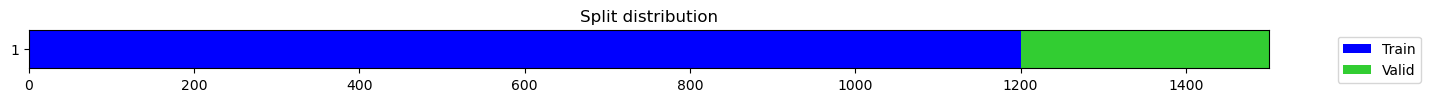

((#1200) [0,1,2,3,4,5,6,7,8,9...],
 (#300) [1200,1201,1202,1203,1204,1205,1206,1207,1208,1209...])

In [438]:
splits = get_splits(y,
                    valid_size=.2,
                    stratify=True,
                    random_state=23,
                    shuffle=False)
splits

In [471]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

TypeError: unhashable type: 'numpy.ndarray'

## Data from 3d array

In [8]:
# # dataset id
# dsid = 'NATOPS' 
# A, v, s = get_UCR_data(dsid, return_split=False)

# A.shape, v.shape, s

In [9]:
# tX = A[:, 23]
# ty = v.reshape(-1, 1)
# tdata = np.concatenate((tX, ty), axis=-1)
# tsdf = pd.DataFrame(tdata).astype(float)
# print(tX.shape, ty.shape)
# tsdf

In [40]:
df

,ledGreen,accelerometer,gyroscope,bpm,breathingrate,hr,sleep_state
0,44.017837,4031.366270,218.972601,NaN,NaN,37.23489660640545,0
1,243.316094,4033.261614,240.587822,NaN,NaN,36.14947820780132,0
2,628.524031,4035.257737,262.429038,NaN,NaN,34.80195512238786,0
3,1037.882909,4039.649737,271.788061,NaN,NaN,33.8155375957624,0
4,1252.057796,4044.051063,283.347843,NaN,NaN,33.38660268613536,0
...,...,...,...,...,...,...,...
18361495,-11.158270,4051.925252,243.693455,75.0,0.166667,17.636103,1
18361496,-5.812718,4051.898567,255.164653,75.0,0.166667,17.432848,1
18361497,0.404518,4048.076827,228.317761,75.0,0.166667,17.390665,1
18361498,6.903495,4048.000896,238.055666,75.0,0.166667,17.770973,1


In [49]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder


scaler = RobustScaler()
le = LabelEncoder()

temp_df = df[['ledGreen', 'accelerometer', 'gyroscope', 'hr', 'sleep_state']].interpolate(method='spline', order=4).dropna()

X = scaler.fit_transform(temp_df[['ledGreen', 'accelerometer', 'gyroscope', 'hr']])
y = le.fit_transform(temp_df['sleep_state'])

# selecting sequences range
X = X[0:(len(X) - len(X)%1500)]
y = y[0:(len(y) - len(y)%1500)]

pd.DataFrame(X)

,0,1,2,3
0,5.005262,-0.583656,-0.368280,1.138988
1,27.216020,-0.567479,-0.207301,1.086525
2,70.145449,-0.550441,-0.044638,1.021394
3,115.766375,-0.512953,0.025064,0.973717
4,139.635056,-0.475385,0.111155,0.952985
...,...,...,...,...
15721495,2.708156,-0.407826,-0.335350,1.527933
15721496,2.428650,-0.401010,-0.301580,1.518093
15721497,2.107217,-0.394192,-0.263747,1.467844
15721498,1.743975,-0.421010,-0.259609,1.383151


In [50]:
# epoch lenght 60 seconds (25hz * 60 = 1500)
# 12241 epochs
sht = len(X) // 1500
print("Shape: ", sht)

X = X.T.reshape(sht, 4, 1500)
y = y.T.reshape(sht, 1500)
y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

X.shape, y.shape

Shape:  10481


((10481, 4, 1500), (10481,))

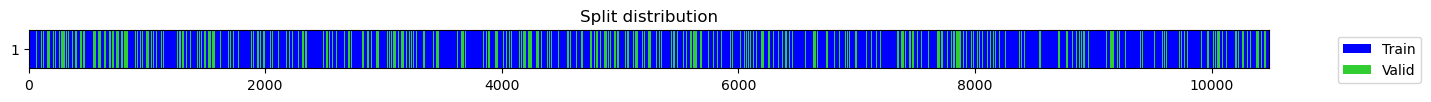

((#7337) [891,6111,5562,8879,2146,6828,5026,7070,4736,8931...],
 (#3144) [2706,3841,7826,9335,7454,9221,1408,2804,8472,9804...])

In [92]:
splits = get_splits(y,
                    valid_size=.3,
                    stratify=False,
                    random_state=6565,
                    shuffle=True)
splits

In [93]:
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

## Dataloaders

In [94]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

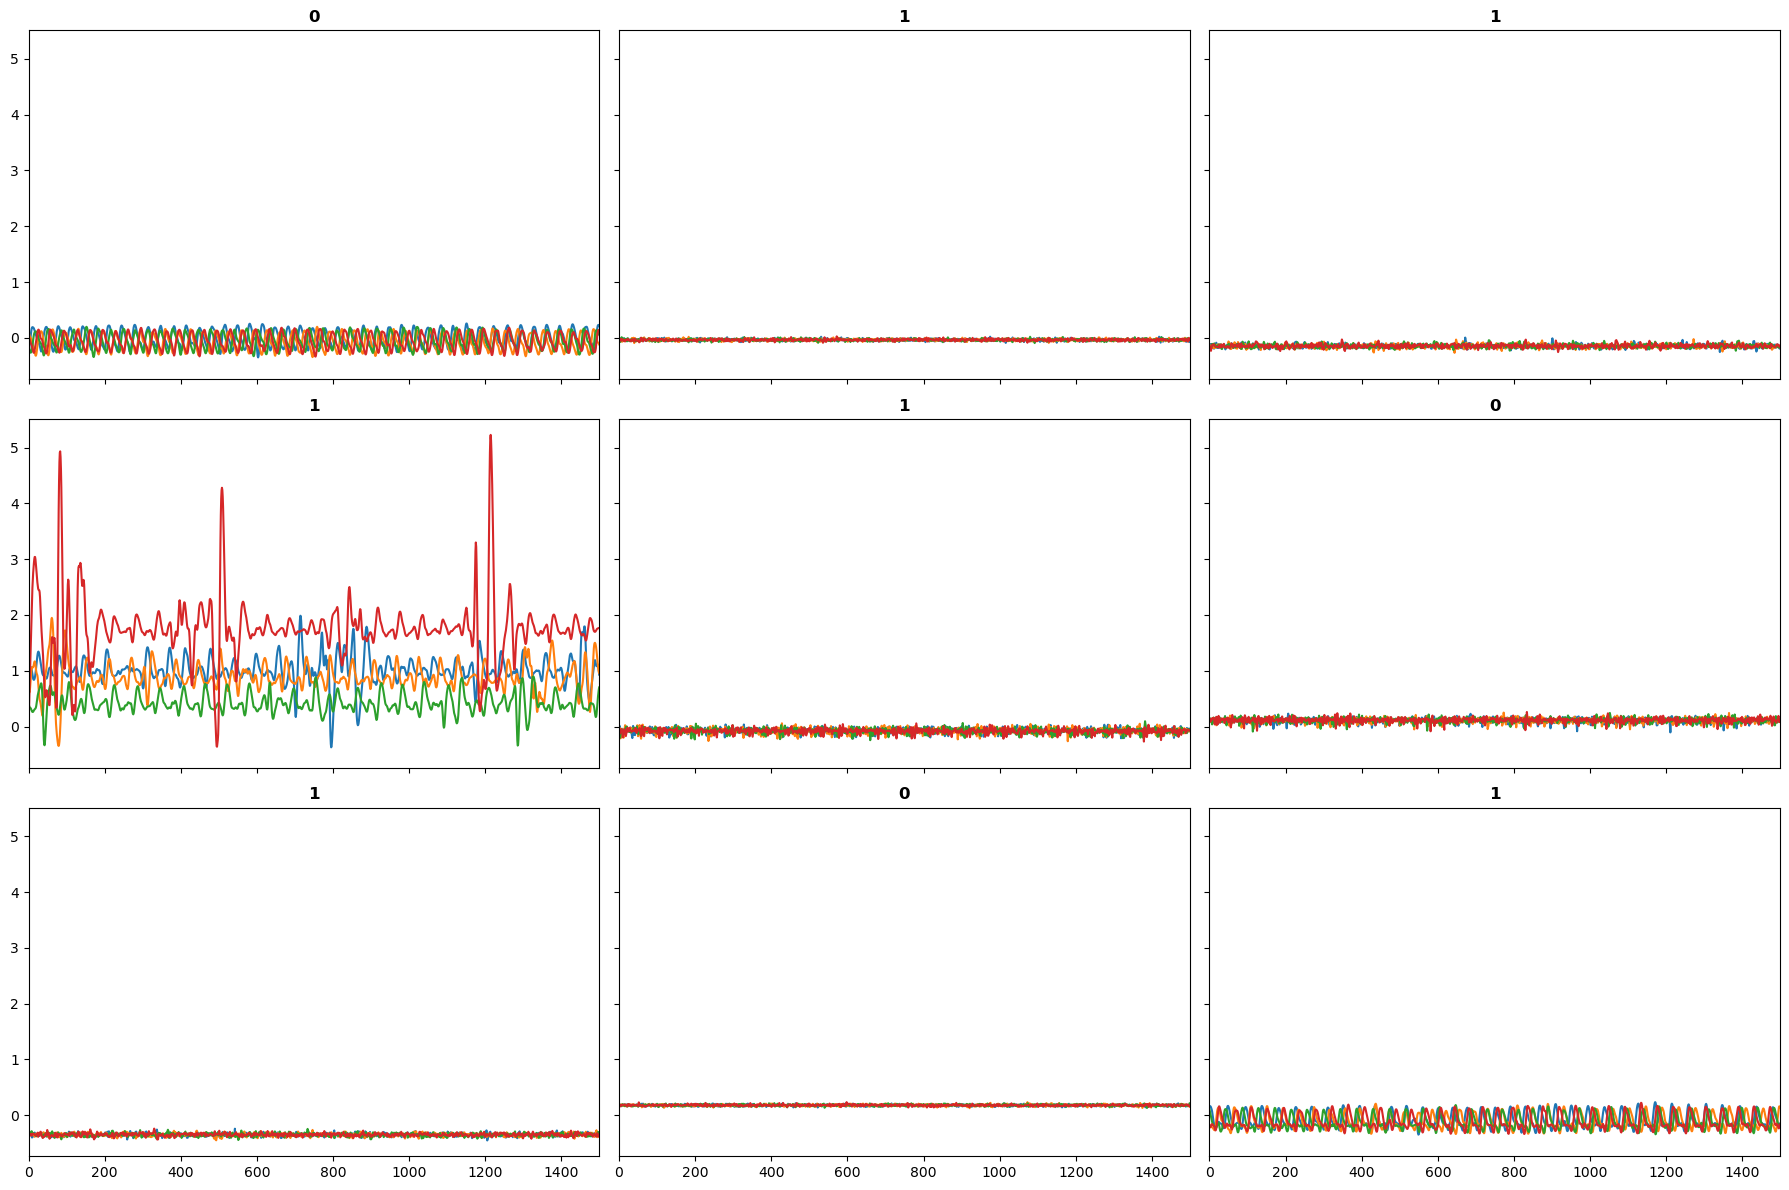

In [95]:
dls.show_batch(sharey=True)

## Build learner

In [96]:
# model = InceptionTime(
#     dls.vars,
#     dls.c,
# )
# learn = Learner(dls, model, metrics=accuracy)
# learn.save('stage0')

In [97]:
archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}),
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}),
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]


for i, (arch, k) in enumerate(archs):
    print(f'arch: {arch.__name__}')

# results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
# for i, (arch, k) in enumerate(archs):
#     model = create_model(arch, dls=dls, **k)
#     print(model.__class__.__name__)
#     learn = Learner(dls, model,  metrics=accuracy)
#     start = time.time()
#     learn.fit_one_cycle(5, 1e-3)
#     elapsed = time.time() - start
#     vals = learn.recorder.values[-1]
#     results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
#     results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
#     clear_output()
#     display(results)

arch: FCN
arch: ResNet
arch: xresnet1d34
arch: ResCNN
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM_FCN
arch: LSTM_FCN
arch: InceptionTime
arch: XceptionTime
arch: OmniScaleCNN
arch: mWDN


In [98]:
model = create_model(LSTM, dls=dls, **{})

In [99]:
learn = Learner(dls, model, metrics=accuracy)

## LR find

SuggestedLRs(valley=0.0063095735386013985)

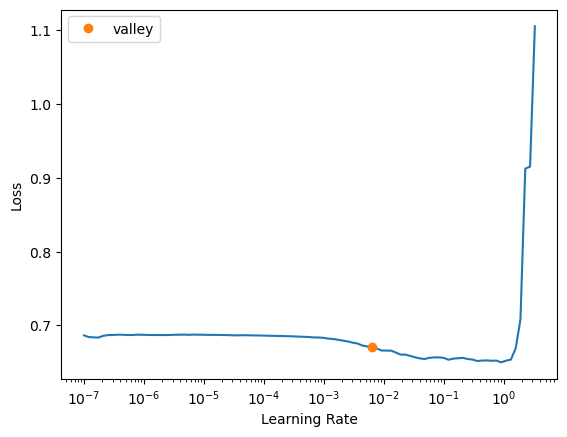

In [100]:
# learn.load('stage0')
learn.lr_find()

In [101]:
learn.fit_one_cycle(5, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.635070,0.610146,0.701336,00:18
1,0.620567,0.608201,0.700700,00:18
2,0.613617,0.606468,0.701018,00:18
3,0.612632,0.607197,0.700700,00:17
4,0.610996,0.606598,0.700382,00:18


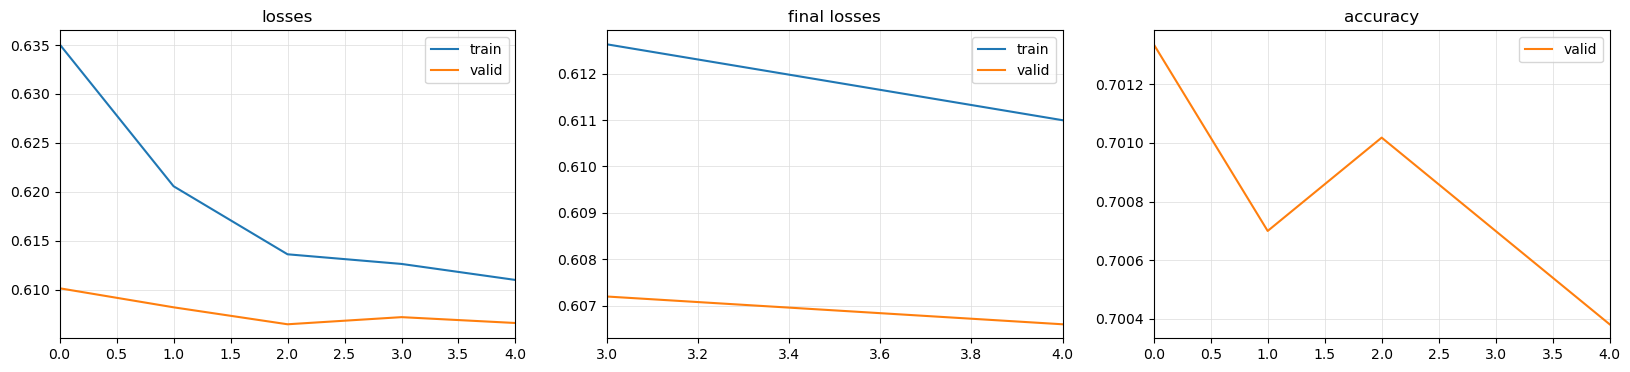

In [102]:
learn.plot_metrics()

In [103]:
learn.save('stage1')

Path('models/stage1.pth')

In [ ]:
learn.save_all(path='export',
               dls_fname='dls',
               model_fname='model',
               learner_fname='learner')

## Inferece


In [104]:
# learn = load_learner_all(path='export',
#                          dls_fname='dls',
#                          model_fname='model',
#                          learner_fname='learner')

dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:4, len:1500, device=cuda:0, dtype=torch.float32),
 TensorCategory([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
         1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
         1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
         1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0'))

In [105]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl,
                                                           with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[0.3931, 0.6069],
         [0.3285, 0.6715],
         [0.3189, 0.6811],
         ...,
         [0.2925, 0.7075],
         [0.2731, 0.7269],
         [0.3102, 0.6898]]),
 tensor([0, 1, 1,  ..., 0, 1, 0]),
 tensor([1, 1, 1,  ..., 1, 1, 1]))

In [106]:
(valid_targets == valid_preds).float().mean()

tensor(0.7004)

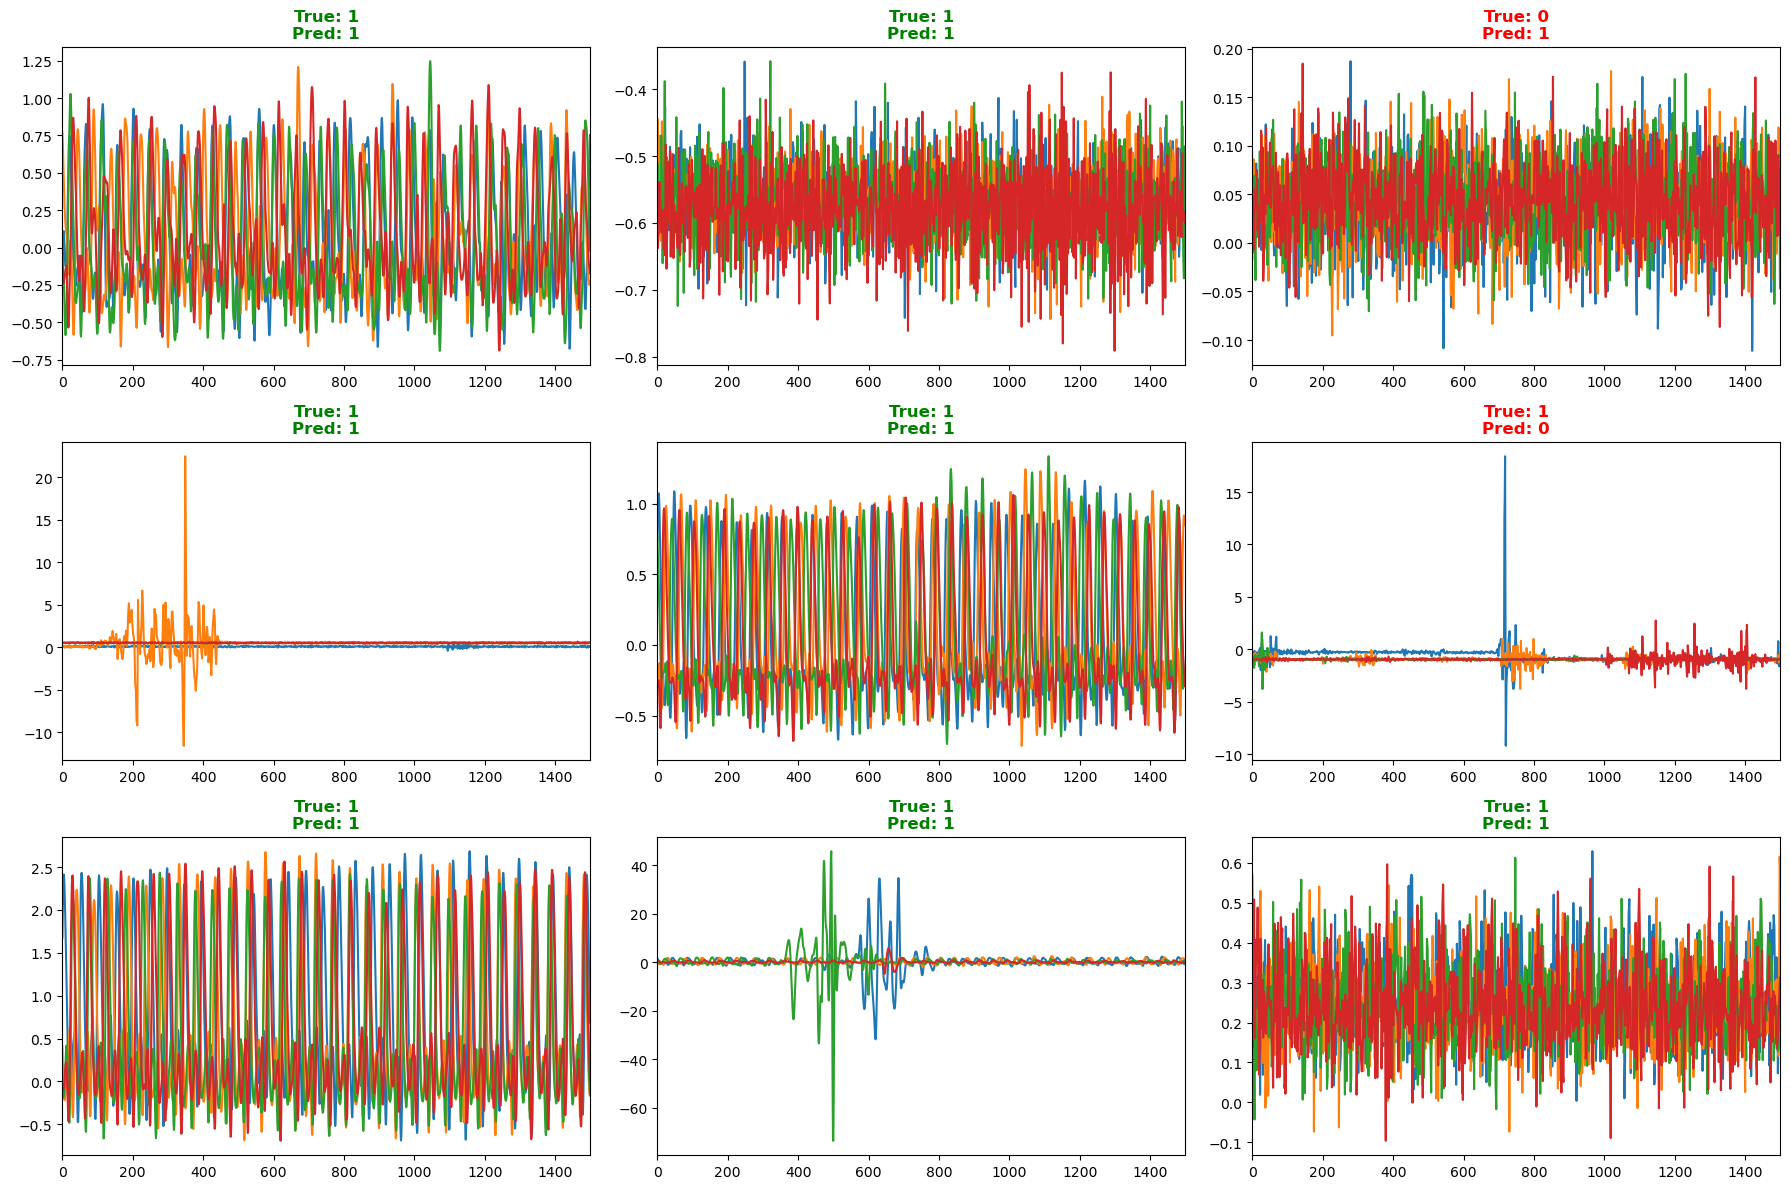

In [107]:
learn.show_results()


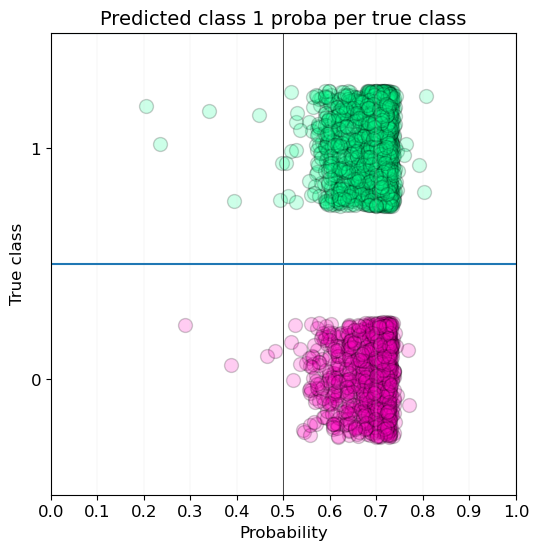

In [108]:
learn.show_probas()


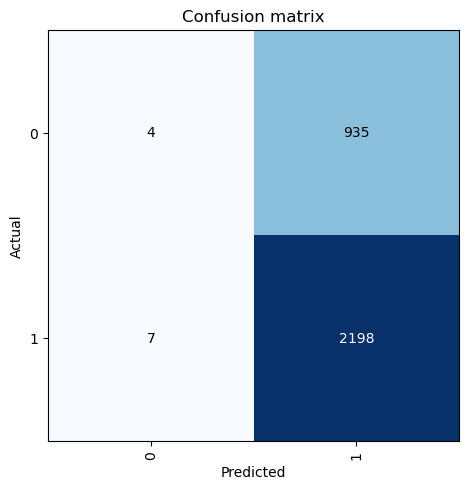

In [109]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [110]:
interp.most_confused(min_val=3)

[(0, 1, 935), (1, 0, 7)]

In [111]:
print(f'accuracy: {skm.accuracy_score(valid_targets, valid_preds):10.6f}')

accuracy:   0.700382


# inference on unseen data

In [112]:
# Read the data
test_data = pd.read_csv('final_test_processed.csv', index_col=0)

# select the columns
test_data = test_data[['ledGreen', 'accelerometer', 'gyroscope', 'hr',
                'sleep_state']].interpolate(method='spline', order=4).dropna()

# drop rows where 'hr' column have values starting with '['
test_data = test_data[~test_data['hr'].str.startswith('[', na=False)]

test_data.reset_index(drop=True, inplace=True)

In [113]:
test_data

,ledGreen,accelerometer,gyroscope,hr,sleep_state
0,81.099061,4193.748204,227.129919,7.871621,0
1,448.425521,4188.334066,234.546904,6.814756,0
2,1158.939516,4182.935453,243.854465,6.344712,0
3,1915.355496,4185.416526,232.191731,6.601495,0
4,2313.691734,4187.903891,220.827987,7.252714,0
...,...,...,...,...,...
1726495,2.509672,4034.785744,263.024714,13.990475,1
1726496,5.263592,4036.533352,259.495665,13.193912,1
1726497,7.742607,4038.286023,257.631520,12.688979,1
1726498,9.844872,4038.391842,255.610381,12.523456,1


In [114]:
scaler = RobustScaler()
le = LabelEncoder()

X_test = scaler.fit_transform(test_data[['ledGreen', 'accelerometer', 'gyroscope', 'bpm', 'breathingrate', 'hr']])
y_test = le.fit_transform(test_data['sleep_state'])

pd.DataFrame(X_test)

KeyError: "['bpm', 'breathingrate'] not in index"

In [ ]:
# epoch lenght 60 seconds (25hz * 60 = 1500)
sh = len(X_test)//1500 

X_test = X_test.T.reshape(sh, 6, 1500)
y_test = y_test.T.reshape(sh, 1500)
y_test = (y_test.sum(axis=1) // 1500).reshape(-1, 1).flatten()

X_test.shape, y_test.shape

((1145, 6, 1500), (1145,))

In [ ]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(
    X_test, y_test)  # In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:6, len:1500, device=cuda:0, dtype=torch.float32),
 TensorCategory([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'))

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,
                                                        with_decoded=True,
                                                        save_preds=None,
                                                        save_targs=None)
test_probas, test_targets, test_preds


(tensor([[0.1701, 0.8299],
         [0.1699, 0.8301],
         [0.1701, 0.8299],
         ...,
         [0.1833, 0.8167],
         [0.1817, 0.8183],
         [0.1822, 0.8178]]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([1, 1, 1,  ..., 1, 1, 1]))

In [ ]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

accuracy:   0.772052


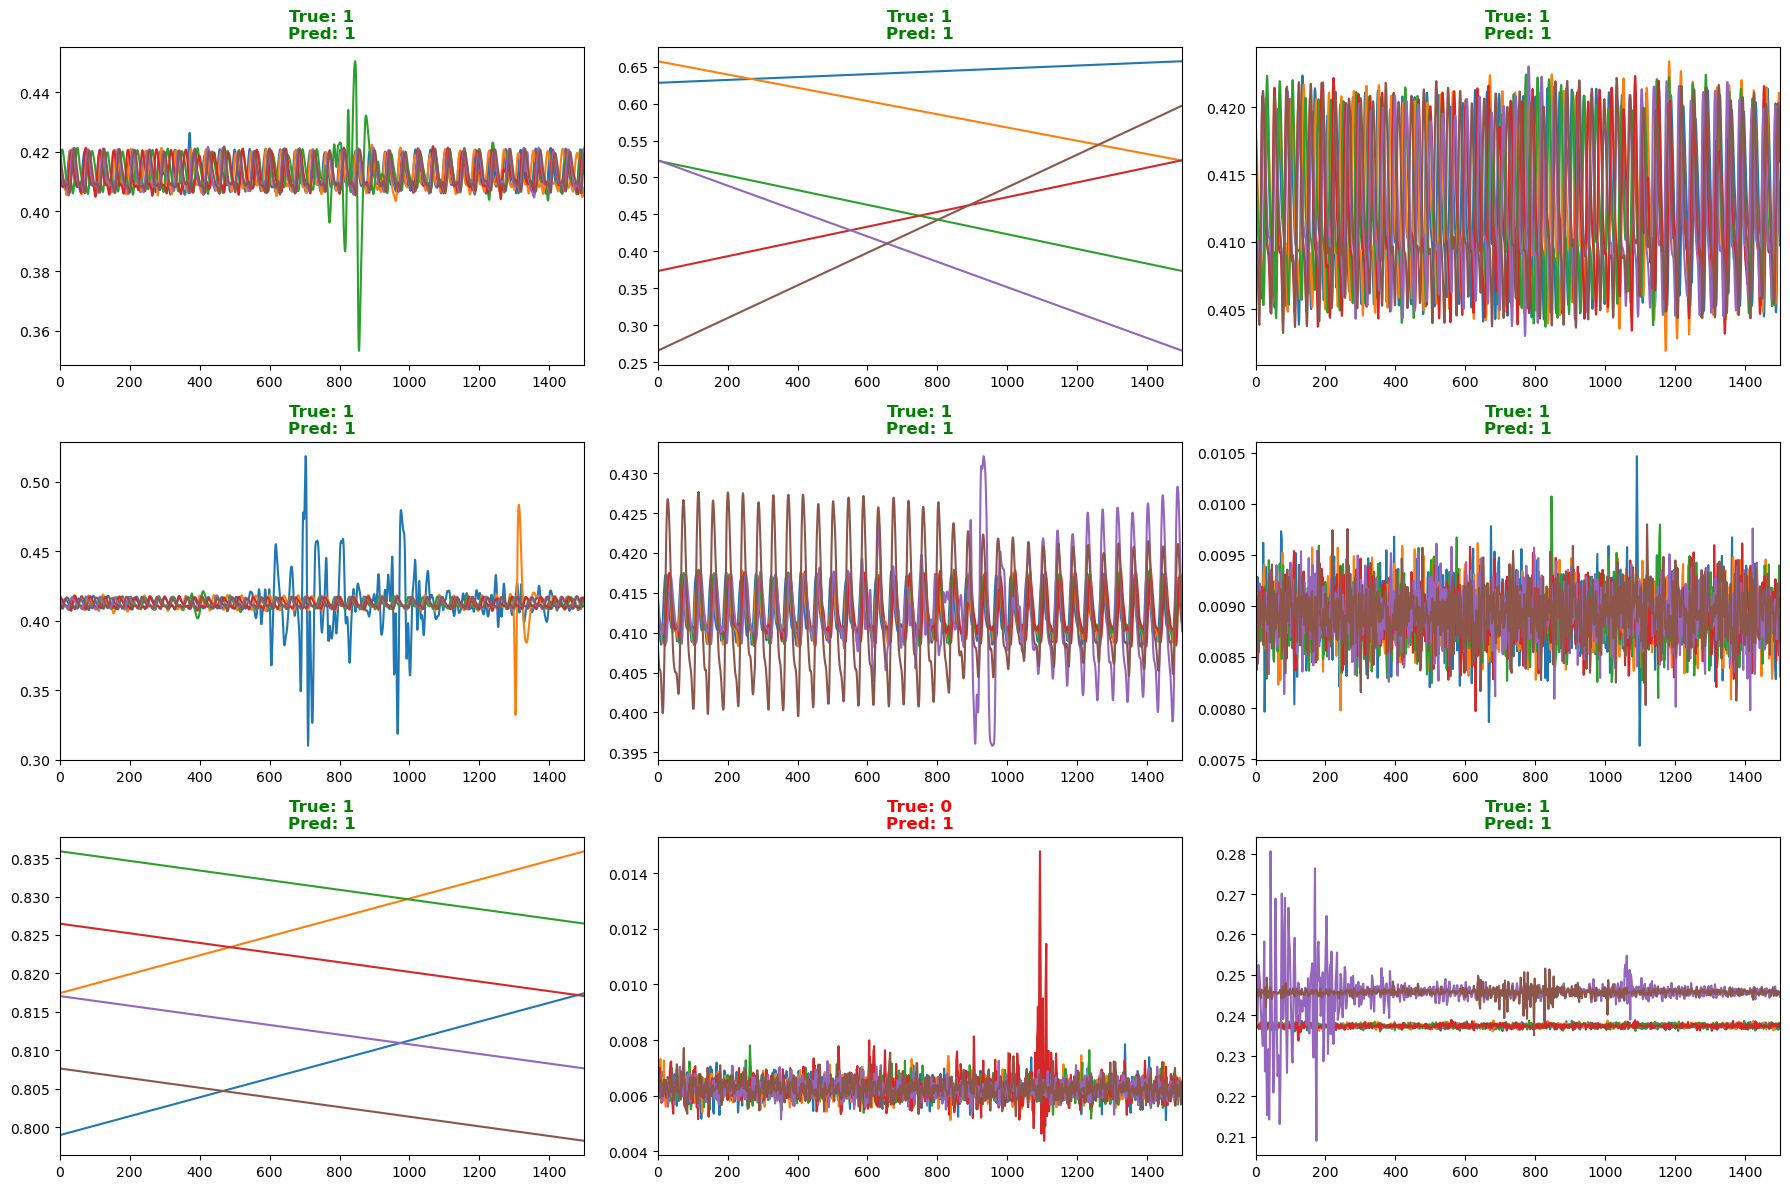

In [ ]:
learn.show_results()


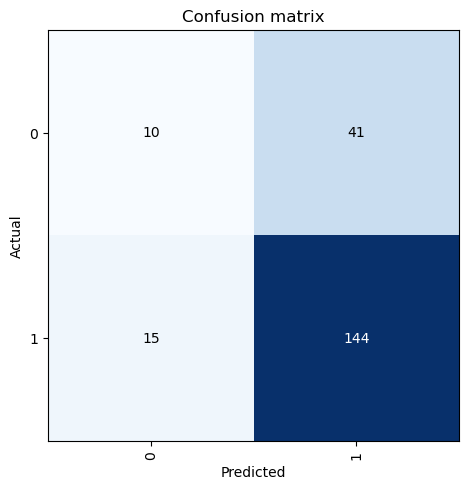

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### If unlabelled data

In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas
